In [1]:
## Imports

## Main Code
# We will use the feature_handler class to extract features from the point clouds
from blobBgone.featureHandler import featureHandler

## MISC
import os
import numpy as np

In [2]:
## Pease, enter your favorite number between between 0 and 500 (for this example)
# We will use this number to select a point cloud from the dataset
number = 11

In [3]:
## Grab the files
# We use the static built-in grab_files method to grab the files from the current directory
# This method returns a list of all the files in the current directory that end with .npy

# If you are on Windows, you can leave the path argument as None to automatically call the explorer

files = featureHandler.grab_files(path = None)

print(f"Found {len(files)} files in the '{files[0].split(os.sep)[-2]}' directory.")

Found 500 files in the 'D:/Frontiers in Bioinformatics/Exemplary Tracks/2D_Mix' directory.


Feature Handler (ID = 261, dimension = 2)

Features in place.
 - None
 
      -------------------------------------- 

 - To get an array of features call featureHandler.to_array()
 - To get a dict of features call featureHandler.to_dict()

 -------------------------------------------------------- 

The Id of the track chosen belongs to the blob category.
Let's check the track to verify this:


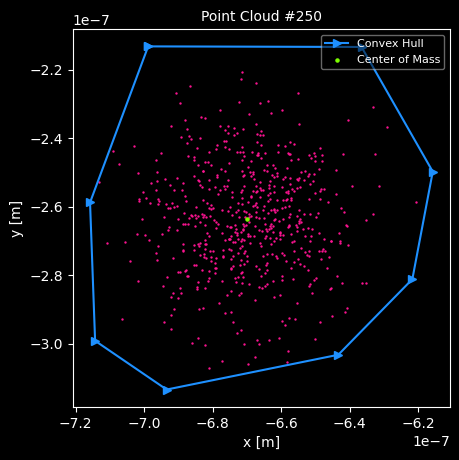

Looks like a blob to me!


In [4]:
## Setup the task list
# We will use the task list to keep track of the files that have been processed
# Each feature handler is designed to handle one point cloud at a time for flexibility

task_list = [featureHandler.from_npy(path = file, verbose = False) for file in files]

# Get a quick look at the first file
print(task_list[number])

# We notice that the point cloud dimension is automatically detected and the ID extracted from the file name
# In this example, the IDs are used to identify if the track is a blob or not
# Reference:
#   - ID in [0,249] -> freely diffusing marker
#   - ID in [250,499] -> blob (zombie marker)

free_ID = range(0,250)
blob_ID = range(250,500)

print("\n -------------------------------------------------------- \n")
print(f"The Id of the track chosen belongs to the {'blob' if task_list[number].ID in blob_ID else 'freely diffusing marker'} category.")
print("Let's check the track to verify this:")

task_list[0].overview()

print(f"Looks like a {'blob' if task_list[number].ID in blob_ID else 'freely diffusing marker'} to me!")

In [5]:
## Featre extraction
# Now that we have everythin gin place, we can extract the features from the point clouds
# We will use the feature_handler class to extract the features from the point clouds by calling the extract() method

features = []
for task in task_list:
    task.extract()
    features.append(task.to_array())
    
# Let's check the features extracted from the our favorite point cloud
print(task_list[number])
    
# In order to effectively use the features during clustering, we need to transform all of them to the same scale/distribution
# Otherwise, the clustering algorithm will be biased towards the features with the largest scale/distribution
method:str = 'standardize' # or 'force_raw
features = featureHandler.regularize_output(features, method = method)
assert np.all(np.isfinite(features)), "NaN values still present in features."

Feature Handler (ID = 261, dimension = 2)

Features in place.
 - features2D(MAX_DIST=1.0733145255163474e-07, CV_AREA=7.178461343455039e-15, SPHE=5.862572243118385, ELLI=1.0783452845042936, CV_DENSITY=8.358337132330592e+16)
 
      -------------------------------------- 

 - To get an array of features call featureHandler.to_array()
 - To get a dict of features call featureHandler.to_dict()


In [6]:
## Clustering ##
# Now here is where the magic happens. We use the KMeans algorithm to cluster the features.
# The number of clusters is set to 2, as we want to separate blobs from the freely diffusing markers
from sklearn.cluster import KMeans

n_cluster = 2

# The default is 'auto', which automatically chooses a value based on the number of features.
n_init = 'auto'

# The 'max_iter' parameter determines how many iterations the algorithm will run before it stops.
max_iter = 300

# Seed the random number generator for reproducibility using the 'random_state' flag.
# For all examples in this notebook, we will keep the seed as 42.
random_state = 42

# Instantiate the KMeans clustering algorithm
clustering_FH  = KMeans(
    n_clusters = n_cluster,
    init = 'k-means++',
    n_init = n_init,
    max_iter = max_iter,
    verbose = 0,
    random_state = random_state,
    )

## Fit the clustering algorithm to the features ##
# In our application we attempt a single shot application of the algorithm, i.e. we do not train the algorithm on a subset of the data and then test it on the rest.
# This has the advantage that we do not need to split the data into training and test sets, which is a problem in our case since we do not have a lot of data.
# We forego time intensive labelling and instead use the clustering algorithm to find similar features.

fit_predict_FH = clustering_FH.fit_predict(features)

------------------------------

Cluster 1: 251 tasks
Cluster 2: 249 tasks

Cluster1
Low_end_ID: 1
High_end_ID: 304

Cluster2
Low_end_ID: 250
High_end_ID: 499

------------------------------

Track Mismatches:[274, 304]

Blob Mismatches:[]

Total number of mismatches: 2

------------------------------

Accuracy: 0.996
F1 Score: 0.995999935998976

------------------------------



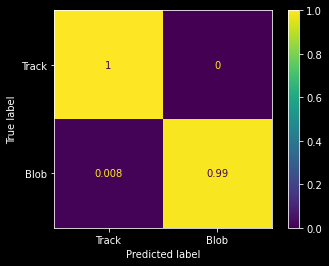

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score

cluster_1 = [task for task in task_list if fit_predict_FH[task.ID] == 0]
cluster_2 = [task for task in task_list if fit_predict_FH[task.ID] == 1]

print("------------------------------\n")

print('Cluster 1: {} tasks'.format(len(cluster_1)))
print('Cluster 2: {} tasks'.format(len(cluster_2)))

print(f"\nCluster1\nLow_end_ID: {min([task.ID for task in cluster_1])}\nHigh_end_ID: {max([task.ID for task in cluster_1])}")
print(f"\nCluster2\nLow_end_ID: {min([task.ID for task in cluster_2])}\nHigh_end_ID: {max([task.ID for task in cluster_2])}")

print("\n------------------------------\n")
print(f"Track Mismatches:{[task.ID for task in cluster_1 if task.ID not in free_ID]}")
print(f"\nBlob Mismatches:{[task.ID for task in cluster_2 if task.ID not in blob_ID]}")

print(f"\nTotal number of mismatches: {len([task.ID for task in cluster_1 if task.ID not in free_ID]) + len([task.ID for task in cluster_2 if task.ID not in blob_ID])}")

print("\n------------------------------\n")
print(f"Accuracy: {accuracy_score([0 for i in free_ID] + [1 for i in blob_ID], fit_predict_FH, normalize=True)}")
print(f"F1 Score: {f1_score([0 for i in free_ID] + [1 for i in blob_ID], fit_predict_FH, average='macro')}")
print("\n------------------------------\n")

cm = confusion_matrix([0 for i in free_ID] + [1 for i in blob_ID], fit_predict_FH, normalize='true')
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Track', 'Blob']).plot()

### That looks pretty good. We have successfully separated blobs and freely moving markers.

---------------------------------------------------------------------------------------------------------

### Here is a compiled version of the code above:

In [8]:
def BlobBGone(path:str = None, return_IDs:bool = False, regularization_method:str = 'standardize', verbose:bool = True):
    import os
    import numpy as np
    from sklearn.cluster import KMeans
    from blobBgone.featureHandler import featureHandler
    
    # Grab the files
    files = featureHandler.grab_files(path = None)
    if verbose:
        print(f"Found {len(files)} files in the '{files[0].split(os.sep)[-2]}' directory.")
        
    # Setup the task list
    task_list = [featureHandler.from_npy(path = file, verbose = False) for file in files]
    
    if verbose:
        print("\nExtracting features...")
    # Extract features
    features = []
    for task in task_list:
        task.extract()
        features.append(task.to_array())

    # Regularize the features
    features = featureHandler.regularize_output(features, method = regularization_method)
    assert np.all(np.isfinite(features)), "NaN values still present in features."


    if verbose:
        print("\nClustering...")
    # Cluster the features
    clustering_FH  = KMeans(
        n_clusters = 2,
        init = 'k-means++',
        n_init = 'auto',
        max_iter = 300,
        verbose = 0,
        random_state = None,
        )
    fit_predict_FH = clustering_FH.fit_predict(features)
    
    cluster_1 = [task for task in task_list if fit_predict_FH[task.ID] == 0]
    cluster_2 = [task for task in task_list if fit_predict_FH[task.ID] == 1]
    comb = [cluster_1, cluster_2]
    
    ## Evaluate Blobbness ##
    # this is an experimental metric that attempts to decide what cluster is the blob cluster
    if verbose:
        print("\nBlobbneess is being calculated...")
    c1_blobbness = np.mean([task.features.SPHE/task.features.MAX_DIST for task in cluster_1])
    c2_blobbness = np.mean([task.features.SPHE/task.features.MAX_DIST for task in cluster_2])
    if verbose:
        print("Cluster 1 blobbness: {:.2f}".format(c1_blobbness))
        print("Cluster 2 blobbness: {:.2f}".format(c2_blobbness))
        print("Blobbness ratio: 1 : {:.2f}".format(max([c1_blobbness, c2_blobbness])/min([c1_blobbness, c2_blobbness])))
    

    if not return_IDs:
        blobs = [task for task in comb[np.argmax([c1_blobbness, c2_blobbness])]]
        free =  [task for task in comb[np.argmin([c1_blobbness, c2_blobbness])]]
        return blobs, free

    blobs = [task.ID for task in comb[np.argmax([c1_blobbness, c2_blobbness])]]
    free =  [task.ID for task in comb[np.argmin([c1_blobbness, c2_blobbness])]]
    return blobs, free

In [9]:
## Let's try it out ##
blobs, free = BlobBGone(path = None, return_IDs = False, regularization_method = 'standardize', verbose = True)

Found 500 files in the 'D:/Frontiers in Bioinformatics/Exemplary Tracks/2D_Mix' directory.

Extracting features...

Clustering...

Blobbneess is being calculated...
Cluster 1 blobbness: 51323066.11
Cluster 2 blobbness: 4058756.06
Blobbness ratio: 1 : 12.65


In [10]:
blobs[0]

Feature Handler (ID = 250, dimension = 2)

Features in place.
 - features2D(MAX_DIST=1.1569219503915216e-07, CV_AREA=8.038720851869289e-15, SPHE=6.505285950470109, ELLI=1.1151869335690463, CV_DENSITY=7.46387405479416e+16)


 
      -------------------------------------- 

 - To get an array of features call featureHandler.to_array()
 - To get a dict of features call featureHandler.to_dict()

Suspected Zombie Marker (Blob)

------------------------------



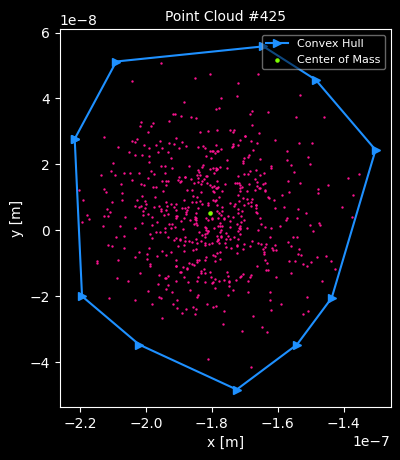

Suspected Free Marker

------------------------------



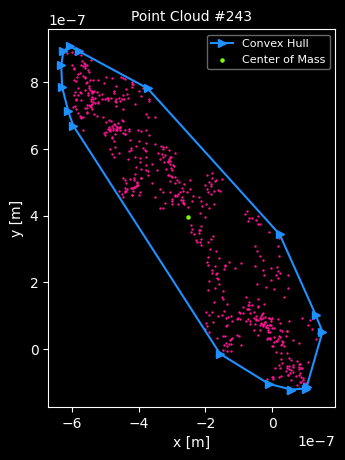

In [11]:
## Seeing is believing ##
print("Suspected Zombie Marker (Blob)")
print("\n------------------------------\n")
blobs[np.random.randint(0,len(blobs))].overview()

print("Suspected Free Marker")
print("\n------------------------------\n")
free[np.random.randint(0,len(free))].overview()